In [108]:
!pip install -qU langgraph langchain langchain-groq ezyml  gradio


In [109]:
import os
import json
from datetime import datetime
from typing import TypedDict, Optional, List

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pydantic import BaseModel

from langgraph.graph import StateGraph, END
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from ezyml.core import EZTrainer

In [110]:
class AgentState(TypedDict):
    user_query: str
    dataset_path: str
    intent: Optional[dict]
    eda_done: bool

    ml_result: Optional[dict]
    leaderboard: Optional[List[dict]]

    retries: int
    final_response: Optional[str]

In [111]:
class IntentSchema(BaseModel):
    task: str
    ml_type: str
    target_column: str
    optimization_goal: str
    preferred_models: Optional[List[str]] = None

In [113]:
from google.colab import userdata
import os

os.environ["GROQ_API_KEY"] = userdata.get("groq")

print("✅ GROQ_API_KEY loaded:", bool(os.environ.get("GROQ_API_KEY")))

✅ GROQ_API_KEY loaded: True


In [114]:
llm = ChatGroq(
    model="qwen/qwen3-32b",
    temperature=0,
    reasoning_format="parsed",
    max_retries=2,
)


In [115]:
PLANNER_PROMPT = ChatPromptTemplate.from_messages([
    ("system",
     "You are the MAIN data-science planner.\n"
     "You decide WHAT to do, not HOW.\n"
     "You NEVER choose ML algorithms.\n"
     "Return valid JSON only. The JSON must adhere to the following schema:\n"
     "```json\n{{\n  \"task\": \"classification\" | \"regression\" | \"clustering\" | \"other\",\n  \"ml_type\": \"classification\" | \"regression\",\n  \"target_column\": \"name_of_target_column\",\n  \"optimization_goal\": \"accuracy\" | \"f1\" | \"r2\" | \"mae\" | \"mse\",\n  \"preferred_models\": [\"logistic_regression\", \"random_forest\", \"xgboost\", \"svm\", \"knn\", \"linear_regression\", \"ridge\", \"lasso\"] | null\n}}\n```\n"
     "Extract any mentioned preferred model names from the user query (e.g., 'logistic_regression', 'random_forest', 'xgboost', 'svm', 'knn', 'linear_regression', 'ridge', 'lasso') and list them in the 'preferred_models' field. If no specific models are mentioned, set 'preferred_models' to null."),
    ("human",
     """
User request:
{query}

Dataset columns:
{columns}

Return intent JSON.
""")
])

planner_chain = PLANNER_PROMPT | llm

def planner_agent(state: AgentState):
    df = pd.read_csv(state["dataset_path"])

    response = planner_chain.invoke({
        "query": state["user_query"],
        "columns": list(df.columns)
    })

    # Extract JSON from markdown code block if present
    json_content = response.content.strip()
    if json_content.startswith("```json") and json_content.endswith("```"):
        json_content = json_content[len("```json"): -len("```")].strip()

    intent = IntentSchema.model_validate_json(json_content)

    return {
        **state,
        "intent": intent.model_dump(exclude_none=False),
        "eda_done": False,
        "retries": 0
    }

In [116]:
def eda_agent(state: AgentState):
    df = pd.read_csv(state["dataset_path"])
    target = state["intent"]["target_column"]

    display(df.head())
    display(df.describe())

    plt.figure(figsize=(6, 4))
    sns.histplot(df[target], kde=True)
    plt.title("Target Distribution")
    plt.show()

    return {
        **state,
        "eda_done": True
    }


In [117]:
def feature_engineering_agent(state: AgentState):
    df = pd.read_csv(state["dataset_path"])

    # Encode categoricals
    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].astype("category").cat.codes

    # Handle missing values
    for col in df.select_dtypes(include=["number"]).columns:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)

    new_path = "feature_engineered_data.csv"
    df.to_csv(new_path, index=False)

    print("🧠 Feature engineering applied")

    return {
        **state,
        "dataset_path": new_path
    }


In [118]:
MODEL_POOLS = {
    "classification": [
        "logistic_regression",
        "random_forest",
        "xgboost",
        "svm",
        "knn"
    ],
    "regression": [
        "linear_regression",
        "ridge",
        "lasso",
        "random_forest",
        "xgboost"
    ]
}


def ml_agent(state: AgentState):
    intent = state["intent"]
    results = []

    # Map optimization goals to actual metric keys in EZTrainer reports
    metric_key_mapping = {
        "f1": "f1_score",
        "accuracy": "accuracy",
        "r2": "r2",
        "mae": "mae",
        "mse": "mse"
    }

    # Get the actual metric key to use from the report
    optimization_metric_key = metric_key_mapping.get(intent["optimization_goal"], intent["optimization_goal"])

    preferred_models = intent.get("preferred_models")
    if preferred_models and len(preferred_models) > 0:
        models_to_train = preferred_models
    else:
        models_to_train = MODEL_POOLS[intent["ml_type"]]

    for model in models_to_train:
        trainer = EZTrainer(
            data=state["dataset_path"],
            target=intent["target_column"],
            model=model
        )
        trainer.train()

        report = trainer.report
        report["model"] = model
        results.append(report)

    best = max(
        results,
        key=lambda r: r[optimization_metric_key]
    )

    return {
        **state,
        "ml_result": best,
        "leaderboard": results
    }

In [119]:
THRESHOLDS = {
    "accuracy": 0.8,
    "f1": 0.75,
    "r2": 0.7
}


def reflection_agent(state: AgentState):
    intent = state["intent"]
    metric = intent["optimization_goal"]

    # Map optimization goals to actual metric keys in EZTrainer reports
    metric_key_mapping = {
        "f1": "f1_score",
        "accuracy": "accuracy",
        "r2": "r2",
        "mae": "mae",
        "mse": "mse"
    }

    # Get the actual metric key to use from the report
    optimization_metric_key = metric_key_mapping.get(metric, metric)

    score = state["ml_result"][optimization_metric_key]

    if score < THRESHOLDS.get(metric, 0.7) and state["retries"] < 1:
        print("🔁 Metric below threshold — retrying pipeline")
        return {
            **state,
            "retries": state["retries"] + 1,
            "ml_result": None
        }

    return state

In [120]:
EXPERIMENT_DIR = "experiments"
os.makedirs(EXPERIMENT_DIR, exist_ok=True)

def log_experiment(state: AgentState):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    record = {
        "timestamp": timestamp,
        "user_query": state["user_query"],
        "intent": state["intent"],
        "best_model": state["ml_result"],
        "leaderboard": state["leaderboard"]
    }

    path = os.path.join(EXPERIMENT_DIR, f"experiment_{timestamp}.json")
    with open(path, "w") as f:
        json.dump(record, f, indent=2)

    print(f"📊 Experiment logged → {path}")


In [121]:
def response_agent(state: AgentState):
    prompt = f"""
The ML system selected the following model and metrics:

{state['ml_result']}

Explain this result clearly to the user.
"""

    response = llm.invoke(prompt)
    log_experiment(state)

    return {
        **state,
        "final_response": response.content
    }


In [122]:
def router(state: AgentState):
    if not state["eda_done"]:
        return "eda"

    if state["ml_result"] is None and state["retries"] == 0:
        return "feature_eng"

    if state["ml_result"] is None:
        return "ml"

    return "response"


In [123]:
graph = StateGraph(AgentState)

graph.add_node("planner", planner_agent)
graph.add_node("eda", eda_agent)
graph.add_node("feature_eng", feature_engineering_agent)
graph.add_node("ml", ml_agent)
graph.add_node("reflect", reflection_agent)
graph.add_node("response", response_agent)

graph.set_entry_point("planner")

graph.add_edge("planner", "eda")
graph.add_edge("eda", "feature_eng")
graph.add_edge("feature_eng", "ml")
graph.add_edge("ml", "reflect")

graph.add_conditional_edges(
    "reflect",
    router,
    {
        "ml": "ml",
        "response": "response"
    }
)

graph.add_edge("response", END)

app = graph.compile()

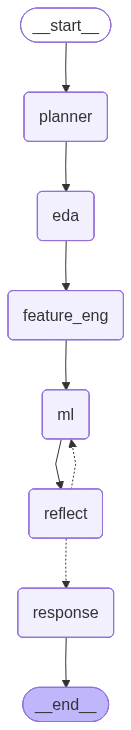

In [124]:
app

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


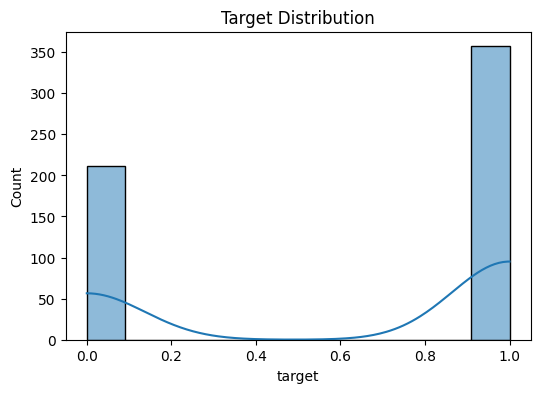

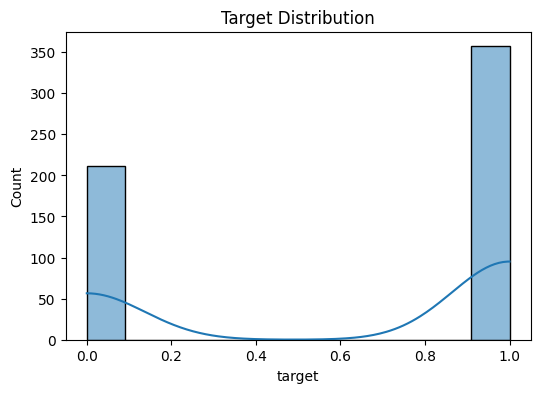

🧠 Feature engineering applied
Loading data from feature_engineered_data.csv...
Task specified as: classification

--- Starting Training for Task: CLASSIFICATION ---
Identified 30 numerical features: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']
Identified 0 categorical features: []
Training xgboost model...
Calculating metrics...
Metrics report:
{
    "accuracy": 0.956140350877193,
    "f1_score": 0.9560357083576898,
    "confusion_matrix": [
        [
            4

In [127]:
result = app.invoke({
    "user_query": "Train the XGBoost for classification model and maximize f1 score",
    "dataset_path": "classification-dataset.csv"  # replace with your CSV
})

print(result["final_response"])


In [ ]:
import gradio as gr

def run_agent(query, dataset_path):
    result = app.invoke({
        "user_query": query,
        "dataset_path": dataset_path
    })
    return result["final_response"]


ui = gr.Interface(
    fn=run_agent,
    inputs=[
        gr.Textbox(label="😊 User Query"),
        gr.Textbox(label="📂 Dataset Path (CSV)")
    ],
    outputs=gr.Textbox(label="📊 Agent Response"),
    title="Agentic Data Science Assistant",
    description="LangGraph + Groq + ezyml — agentic ML without hallucinated models"
)

ui.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b8b1cc0c4c71ac1b08.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
